### Importar librerías

In [1]:
#!pip install surprise

In [1]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats

from surprise import AlgoBase
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

### Calcular Popularidad de ítems

In [2]:
def calculate_item_popularity(df2):
    df = df2.copy()
    # Calcular la cantidad total de usuarios
    total_users = df['user_id'].nunique()

    # Contar la cantidad de usuarios únicos que compraron cada item
    item_user_count = df.groupby('item_id')['user_id'].nunique().reset_index()

    # Renombrar la columna user_id a popularity
    item_user_count = item_user_count.rename(columns={'user_id': 'popularity'})

    # Calcular la popularidad dividiendo por la cantidad total de usuarios
    item_user_count['popularity'] = item_user_count['popularity'] / total_users

    return item_user_count

### Calcular ítems más populares (top 20%)

In [3]:
def get_top_20_percent_items(popularity_df):
    # Ordenar los items por popularidad de mayor a menor
    sorted_popularity_df = popularity_df.sort_values(by='popularity', ascending=False)
    # Calcular el número de ítems que corresponde al 20%
    top_20_percent_count = int(len(sorted_popularity_df) * 0.20)
    # Obtener los ítems más populares que corresponden al 20%
    I_pop = sorted_popularity_df.head(top_20_percent_count)['item_id'].tolist()
    return I_pop

### Calcular popularidad de users

In [4]:
def calculate_user_popularity(df2, I_pop):
    df = df2.copy()
    # Filtrar los items rateados que están en I_pop
    df['is_popular'] = df['item_id'].isin(I_pop)

    # Calcular la cantidad de items populares rateados por cada usuario
    user_popular_items_count = df[df['is_popular']].groupby('user_id')['item_id'].count().reset_index()
    user_popular_items_count = user_popular_items_count.rename(columns={'item_id': 'popular_items_count'})

    # Calcular la cantidad total de items rateados por cada usuario
    user_total_items_count = df.groupby('user_id')['item_id'].count().reset_index()
    user_total_items_count = user_total_items_count.rename(columns={'item_id': 'total_items_count'})

    # Asegurar que todos los usuarios están presentes en el resultado final
    user_popular_items_count = pd.merge(user_total_items_count[['user_id']],
                                        user_popular_items_count,
                                        on='user_id',
                                        how='left').fillna(0)

    # Combinar los dos DataFrames
    user_popularity_df = pd.merge(user_popular_items_count, user_total_items_count, on='user_id')

    # Calcular user_pop dividiendo popular_items_count por total_items_count
    user_popularity_df['user_pop'] = user_popularity_df['popular_items_count'] / user_popularity_df['total_items_count']

    # Seleccionar solo las columnas user_id y user_pop
    user_popularity_df = user_popularity_df[['user_id', 'user_pop']]

    return user_popularity_df

### Prueba con dataset de Netflix

In [5]:
# Cargar el dataset de Netflix
df_netflix = pd.read_csv('./netflix.txt', sep=",", header=None, names=['user_id', 'item_id', 'rating'])

# Seleccionar las columnas relevantes
df_netflix = df_netflix[['user_id', 'item_id', 'rating']]
df_netflix['rating'] = df_netflix['rating'].astype(float)

#take only 3000 users

users = df_netflix['user_id'].unique()
rd.shuffle(users)
users = users[:3000]
df_netflix = df_netflix[df_netflix['user_id'].isin(users)]

# Calcular la popularidad de los ítems
popularity_df = calculate_item_popularity(df_netflix)

# Obtener los ítems del top 20% de popularidad
I_pop = get_top_20_percent_items(popularity_df)

# Calcular la popularidad de los usuarios
user_popularity_df = calculate_user_popularity(df_netflix, I_pop)
user_popularity_df = user_popularity_df.sort_values(by='user_pop', ascending=False)

# Separar usuarios en top, medium y bottom popularity
top, mid, bot = np.array_split(user_popularity_df, 3)

# Mostrar resultados
print("Top 10 usuarios de popularidad alta:\n", top.head(10))
print("Top 10 usuarios de popularidad media:\n", mid.head(10))
print("Top 10 usuarios de popularidad baja:\n", bot.head(10))

Top 10 usuarios de popularidad alta:
       user_id  user_pop
12       6446       1.0
2990  2638198       1.0
1041   913464       1.0
1035   903230       1.0
1029   897462       1.0
972    847607       1.0
1054   921177       1.0
1048   917590       1.0
1049   917642       1.0
1068   932033       1.0
Top 10 usuarios de popularidad media:
       user_id  user_pop
128    107980  0.965986
2492  2213272  0.965909
361    320206  0.965812
165    145490  0.965812
557    501042  0.965798
2537  2254648  0.965686
1900  1685244  0.965517
1699  1505374  0.965517
705    624118  0.965517
1142   995750  0.965517
Top 10 usuarios de popularidad baja:
       user_id  user_pop
2940  2598097  0.892308
973    847615  0.891986
1996  1770582  0.891892
507    453497  0.891892
74      67188  0.891892
1838  1638715  0.891892
1272  1131687  0.891892
2532  2251190  0.891813
355    315988  0.891192
1793  1602731  0.890966


/home/cbenavidesa/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
top.to_csv('./netflix/top.csv', index=False)
mid.to_csv('./netflix/mid.csv', index=False)
bot.to_csv('./netflix/bot.csv', index=False)
df_netflix.to_csv('./netflix/netflix.csv', index=False)

### Inicializar datos

In [7]:
# constants and initialization
folds = 5
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
top_fraction = 0.2

################################################################

df_events = df_netflix.copy()
df_events = df_events.rename(columns={'user_id': 'user', 'item_id': 'item', 'rating': 'preference'})
low_users = bot.copy()
medium_users = mid.copy()
high_users = top.copy()

In [8]:
# read user events and users
cols = ['user', 'item', 'preference']
#df_events = pd.read_csv(user_events_file, sep=',', names=cols, skiprows=1)
print('No. of user events: ' + str(len(df_events)))
# read users
#low_users = pd.read_csv(low_user_file, sep=',').set_index('user')
#medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user')
#high_users = pd.read_csv(high_user_file, sep=',').set_index('user')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))
print('No. of events per user: ' + str(len(df_events) / no_users))

No. of user events: 462636
No. of users: 3000
No. of events per user: 154.212


In [9]:
# get item distribution
item_dist = df_events['item'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users
print('No. of events per item: ' + str(len(df_events) / num_items))

No. items: 10803
No. of events per item: 42.824770896973064


In [10]:
# sparsity
1 - len(df_events) / (no_users * num_items)

0.9857250763676757

In [11]:
# rating range
print('Min rating: ' + str(df_events['preference'].min()))
print('Max rating: ' + str(df_events['preference'].max()))

Min rating: 1.0
Max rating: 5.0


In [12]:
# get fractions
user_hist = [] # user history sizes
pop_item_fraq = [] # average popularity of items in user profiles
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df['item'])) # profile size
    user_hist.append(no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df['item']] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)

R-value: -0.37488330040426693
R2-value: 0.14053748892199583
P-value: 9.883051202799733e-101
Slope: -9.605192795775506e-05
Intercept: 0.1600826802445988
SignificanceResult(statistic=-0.33895240093456874, pvalue=1.520719285066678e-81)


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4')])

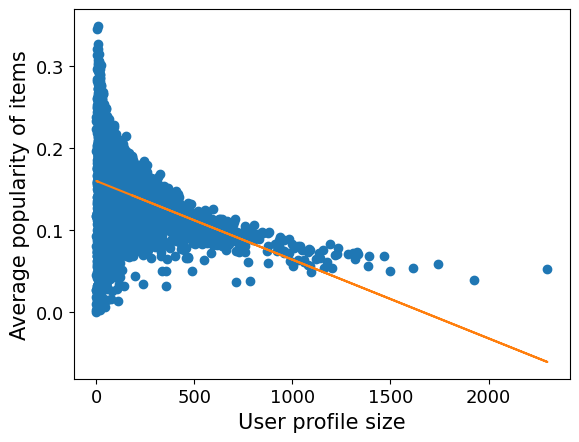

In [13]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print('R2-value: ' + str(r_value**2))
print('P-value: ' + str(p_value))
print('Slope: ' + str(slope))
print('Intercept: ' + str(intercept))
print(stats.spearmanr(user_hist, pop_item_fraq))

line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of items', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
#plt.savefig('data/' + dataset + '/plots/corr_user_avg.png', dpi=300, bbox_inches='tight')

In [14]:
# start recommender

In [15]:
low_users.set_index('user_id', inplace=True)
medium_users.set_index('user_id', inplace=True)
high_users.set_index('user_id', inplace=True)

In [16]:
reader = Reader(rating_scale=(df_events['preference'].min(), df_events['preference'].max()))

In [17]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [18]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [19]:
def get_mae_of_groups(predictions):
    #print('All: ')
    #all_mae = accuracy.mae(predictions)
    all_predictions = []
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        else:
            high_predictions.append(accuracy.mae(prediction, verbose=False))
    low_mae = np.mean(low_predictions)
    #print('LowMS: ' + str(low_mae))
    med_mae = np.mean(med_predictions)
    #print('MedMS: ' + str(med_mae))
    high_mae = np.mean(high_predictions)
    #print('HighMS: ' + str(high_mae))
    all_mae = np.mean([low_mae, med_mae, high_mae])
    #print('All: ' + str(all_mae))
    print('Low vs. med: ' + str(stats.ttest_ind(low_predictions, med_predictions)))
    print('Low vs. high: ' + str(stats.ttest_ind(low_predictions, high_predictions)))

    return low_mae, med_mae, high_mae, all_mae

In [20]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = []

algos.append(KNNBasic(sim_options = sim_users, k=40))
algos.append(KNNWithMeans(sim_options = sim_users, k=40))
algos.append(NMF(n_factors = 30, random_state=my_seed))
algos.append(CoClustering(n_cltr_u=3, n_cltr_i=3, random_state=my_seed))
algo_names = ['KNNBasic',
              'KNNWithMeans',
              'NMF',
              'CoClustering']

kf = KFold(n_splits=folds, random_state = my_seed)
for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_maes = []
    med_maes = []
    high_maes = []
    all_maes = []
    print(algo_names[i])
    fold_count = 0
    for trainset, testset in kf.split(data):
        # calculate and evaluate recommendations
        algos[i].fit(trainset)
        predictions = algos[i].test(testset)
        low_mae, med_mae, high_mae, all_mae = get_mae_of_groups(predictions)
        low_maes.append(low_mae)
        med_maes.append(med_mae)
        high_maes.append(high_mae)
        all_maes.append(all_mae)
        # get top-n recommendation counts
        top_n = get_top_n(predictions, n=10)
        for uid, user_ratings in top_n.items():
            for (iid, _) in user_ratings:
                  df_item_dist.loc[iid, algo_names[i]] += 1

    print('LowMS: ' + str(np.mean(low_maes)))
    print('MedMS: ' + str(np.mean(med_maes)))
    print('HighMS: ' + str(np.mean(high_maes)))
    print('All: ' + str(np.mean(all_maes)))
    print('\n')

KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: TtestResult(statistic=7.43113322753027, pvalue=1.0880132497411826e-13, df=75600.0)
Low vs. high: TtestResult(statistic=9.658554843329132, pvalue=4.699540797888541e-22, df=57631.0)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: TtestResult(statistic=7.75354295527726, pvalue=9.047669749177776e-15, df=75356.0)
Low vs. high: TtestResult(statistic=9.705326343703941, pvalue=2.97559088188111e-22, df=57917.0)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: TtestResult(statistic=7.747786709195427, pvalue=9.467053897850913e-15, df=75282.0)
Low vs. high: TtestResult(statistic=11.30154839090481, pvalue=1.3849898383027842e-29, df=57736.0)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Low vs. med: TtestResult(statistic=6.103104141064006, pvalue=1.045337580838615e-09, df=75291.0)
Low vs. high:

KNNBasic
SignificanceResult(statistic=0.6913499146268893, pvalue=0.0)
KNNWithMeans
SignificanceResult(statistic=0.7182532913571963, pvalue=0.0)
NMF
SignificanceResult(statistic=0.7692141415154861, pvalue=0.0)
CoClustering
SignificanceResult(statistic=0.7064033065843389, pvalue=0.0)


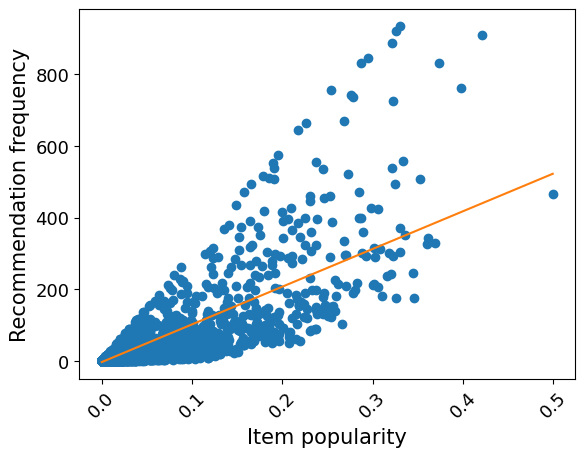

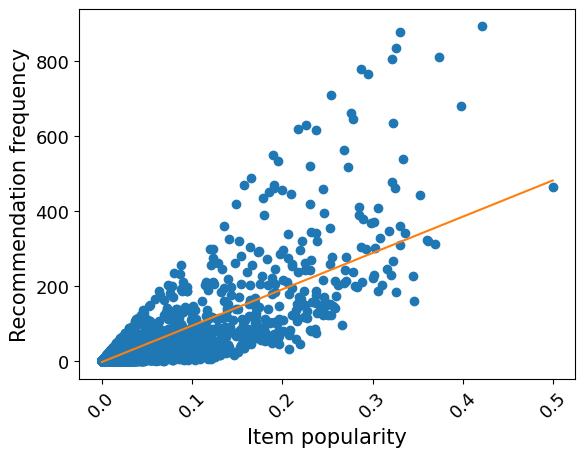

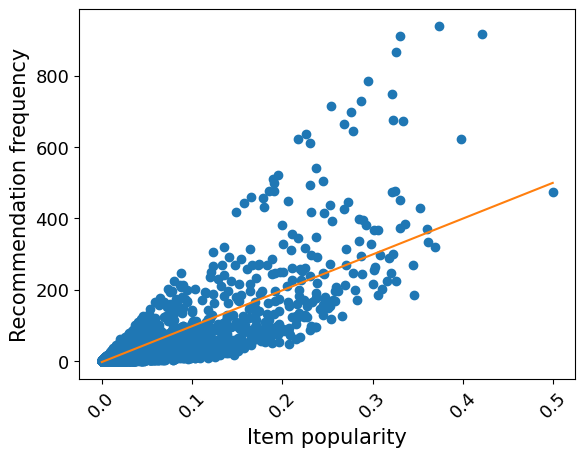

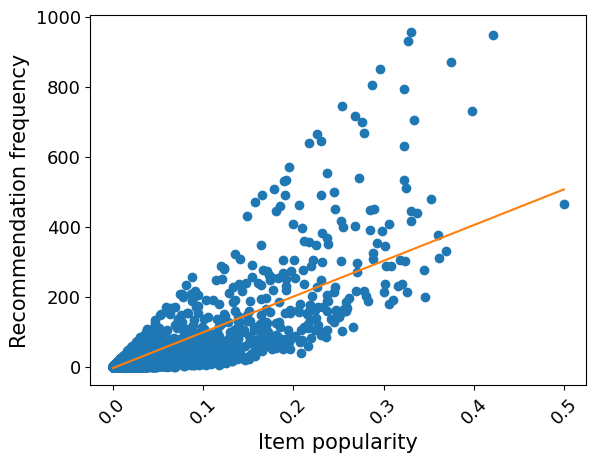

In [ ]:
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    #plt.gca().set_ylim(0, 300)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * np.array(x) + intercept
    print(algo_names[i])
    print(stats.spearmanr(x, y))
    plt.plot(x, y, 'o', x, line)
    plt.xlabel('Item popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.xticks(rotation=45)
    plt.yticks(fontsize='13')
    #plt.savefig('data/' + dataset + '/plots/rec_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')

KNNBasic
* Low Precision: 0.6990442197347377
* Med Precision: 0.7335621997498898
* High Precision: 0.6896502550152903
* All Precision: 0.7074188914999726

* Low Recall: 0.48894730759143945
* Med Recall: 0.49534420168097826
* High Recall: 0.5993432849526282
* All Recall: 0.527878264741682

KNNWithMeans
* Low Precision: 0.662236187337282
* Med Precision: 0.7164635172244248
* High Precision: 0.6679820736768521
* All Precision: 0.682227259412853

* Low Recall: 0.435541162359229
* Med Recall: 0.45352262120218906
* High Recall: 0.5597067368546707
* All Recall: 0.4829235068053629

NMF
* Low Precision: 0.6834958549622333
* Med Precision: 0.7237204749070196
* High Precision: 0.6854078624937843
* All Precision: 0.6975413974543457

* Low Recall: 0.5011932696045307
* Med Recall: 0.5126104738392188
* High Recall: 0.6485169015249694
* All Recall: 0.5541068816562397

CoClustering
* Low Precision: 0.6779051611635708
* Med Precision: 0.7314930149449611
* High Precision: 0.6851077729525936
* All Precision: 0.6981686496870418

* Low Recall: 0.44157177054502084
* Med Recall: 0.4737870243289281
* High Recall: 0.5949311877321879
* All Recall: 0.5034299942020455